# Graph-based Pattern Representations Tutorial

#### Easy Reading: [nbviewer](https://nbviewer.jupyter.org/github/IDEA-NTHU-Taiwan/PatternTutorial/blob/master/Graph-based%20Pattern%20Representations%20Tutorial.ipynb)

#### GitHub Repo: [IDEA-NTHU-Taiwan/PatternTutorial](https://github.com/IDEA-NTHU-Taiwan/PatternTutorial)

#### Example Dataset: [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

#### Author: [Ray](https://github.com/thisray), [Evan](https://github.com/EvanYu800112)

#### Libraries requirements
`matplotlib`, `networkx`, `nltk`, `numpy`, `pandas`, `IDEAlib` (in this repo)

#### References

Saravia Elvis, Carlos Argueta, and Yi-Shin Chen. "Unsupervised graph-based pattern extraction for multilingual emotion classification." Social Network Analysis and Mining 6, no. 1 (2016): 92.

Saravia Elvis, Hsien-Chi Toby Liu, Yen-Hao Huang, Junlin Wu, and Yi-Shin Chen. "CARER: Contextualized Affect Representations for Emotion Recognition." In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, pp. 3687-3697. 2018.

---
## Framework

<img src="./img/0_framework.png" width="600" align="left">

---
### Jupyter notebook setting

In [1]:
%load_ext autoreload
%autoreload 2

class display_df(object):
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

---
## Load data

In [2]:
import IDEAlib as idea
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_colwidth', 100)
np.random.seed(9527)

data_path_sub = './data/train.pkl'
pattern_dir = './pattern_dir'

text_col = 'text'
label_col = 'emotion'

if not os.path.isdir(pattern_dir):
    os.mkdir(pattern_dir)

df_train = pd.read_pickle(data_path_sub)
col_list = [label_col, text_col]
df_train = df_train[col_list]

df_train.head()

emotion  \
1704     fear   
1152     fear   
1038     fear   
3497  sadness   
1940     fear   

                                                                                                     text  
1704  @realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?'  #Tr...  
1152  We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...  
1038  @twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...  
3497                               #PeopleLikeMeBecause of some unknown reason but I try to discourage it  
1940                                       @BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake

## Preprocessing

Finish all the preprocessing tasks here (e.g. splite sentence, tokenize, replace something...)

In [3]:
import nltk

tokenizer = nltk.tokenize.TweetTokenizer()

# preprocessing function
def my_preprocess(text):
    text = idea.utils.tweet_replaceToken(text)
    text = tokenizer.tokenize(text)
    return text

df_train['tokenized_text'] = df_train[text_col].apply(lambda text: my_preprocess(text))

df_train.head()

emotion  \
1704     fear   
1152     fear   
1038     fear   
3497  sadness   
1940     fear   

                                                                                                     text  \
1704  @realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?'  #Tr...   
1152  We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...   
1038  @twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...   
3497                               #PeopleLikeMeBecause of some unknown reason but I try to discourage it   
1940                                       @BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake   

                                                                                           tokenized_text  
1704  [<M>, <M>, new, campaign, slogan, idea, ..., ', i, know, you, are, but, what, am, i, ?, ', <H>, ...  
1152  [we, in, our, own, country, are, so, divided, in, our, approach, so, how, could, we, fight, <H>,...  
1038  [<M>, <M>, <M>, <M>, <M>, <M>, <M>, oh, god, ,, not, brewer, again, ., the, horror, ,, the, horror]  
3497                                    [<H>, of, some, unknown, reason, but, i, try, to, discourage, it]  
1940                                    [<M>, awe, i'm, sorry, !, i, have, 2, dogs, 3, cats, &, a, snake]

---
## 1. Graph construction

<img src="./img/1_GC.png" width="860">        
<br>

Using the neighbor frequency between tokens in all texts to construct a undirected weighted graph, as:

<img src="./img/1_eq.png" width="200">       

construct: `idea.graph.ngramGraph()`    
visualize: `idea.graph.show()`

#### Note:
1. The weight and normalize methods are user-defined.
2. The graph operation of our `idea.graph` library is based on `networkx` python library ([https://github.com/networkx/networkx](https://github.com/networkx/networkx)).   
    There is another efficient graph software `Gephi` ([https://gephi.org/](https://gephi.org/)) you can try.
    

In [4]:
# input form: array or list
tokenized_text = df_train['tokenized_text'].values

# construct graph
graph_sub = idea.graph.ngramGraph(text=tokenized_text, gram_n=2, 
                                  space_token='_space_', max_norm=True, 
                                  take_ratio=1.0, freq_threshold=3)


Graph constructed from (3613) texts, there are (1012) nodes in this graph.


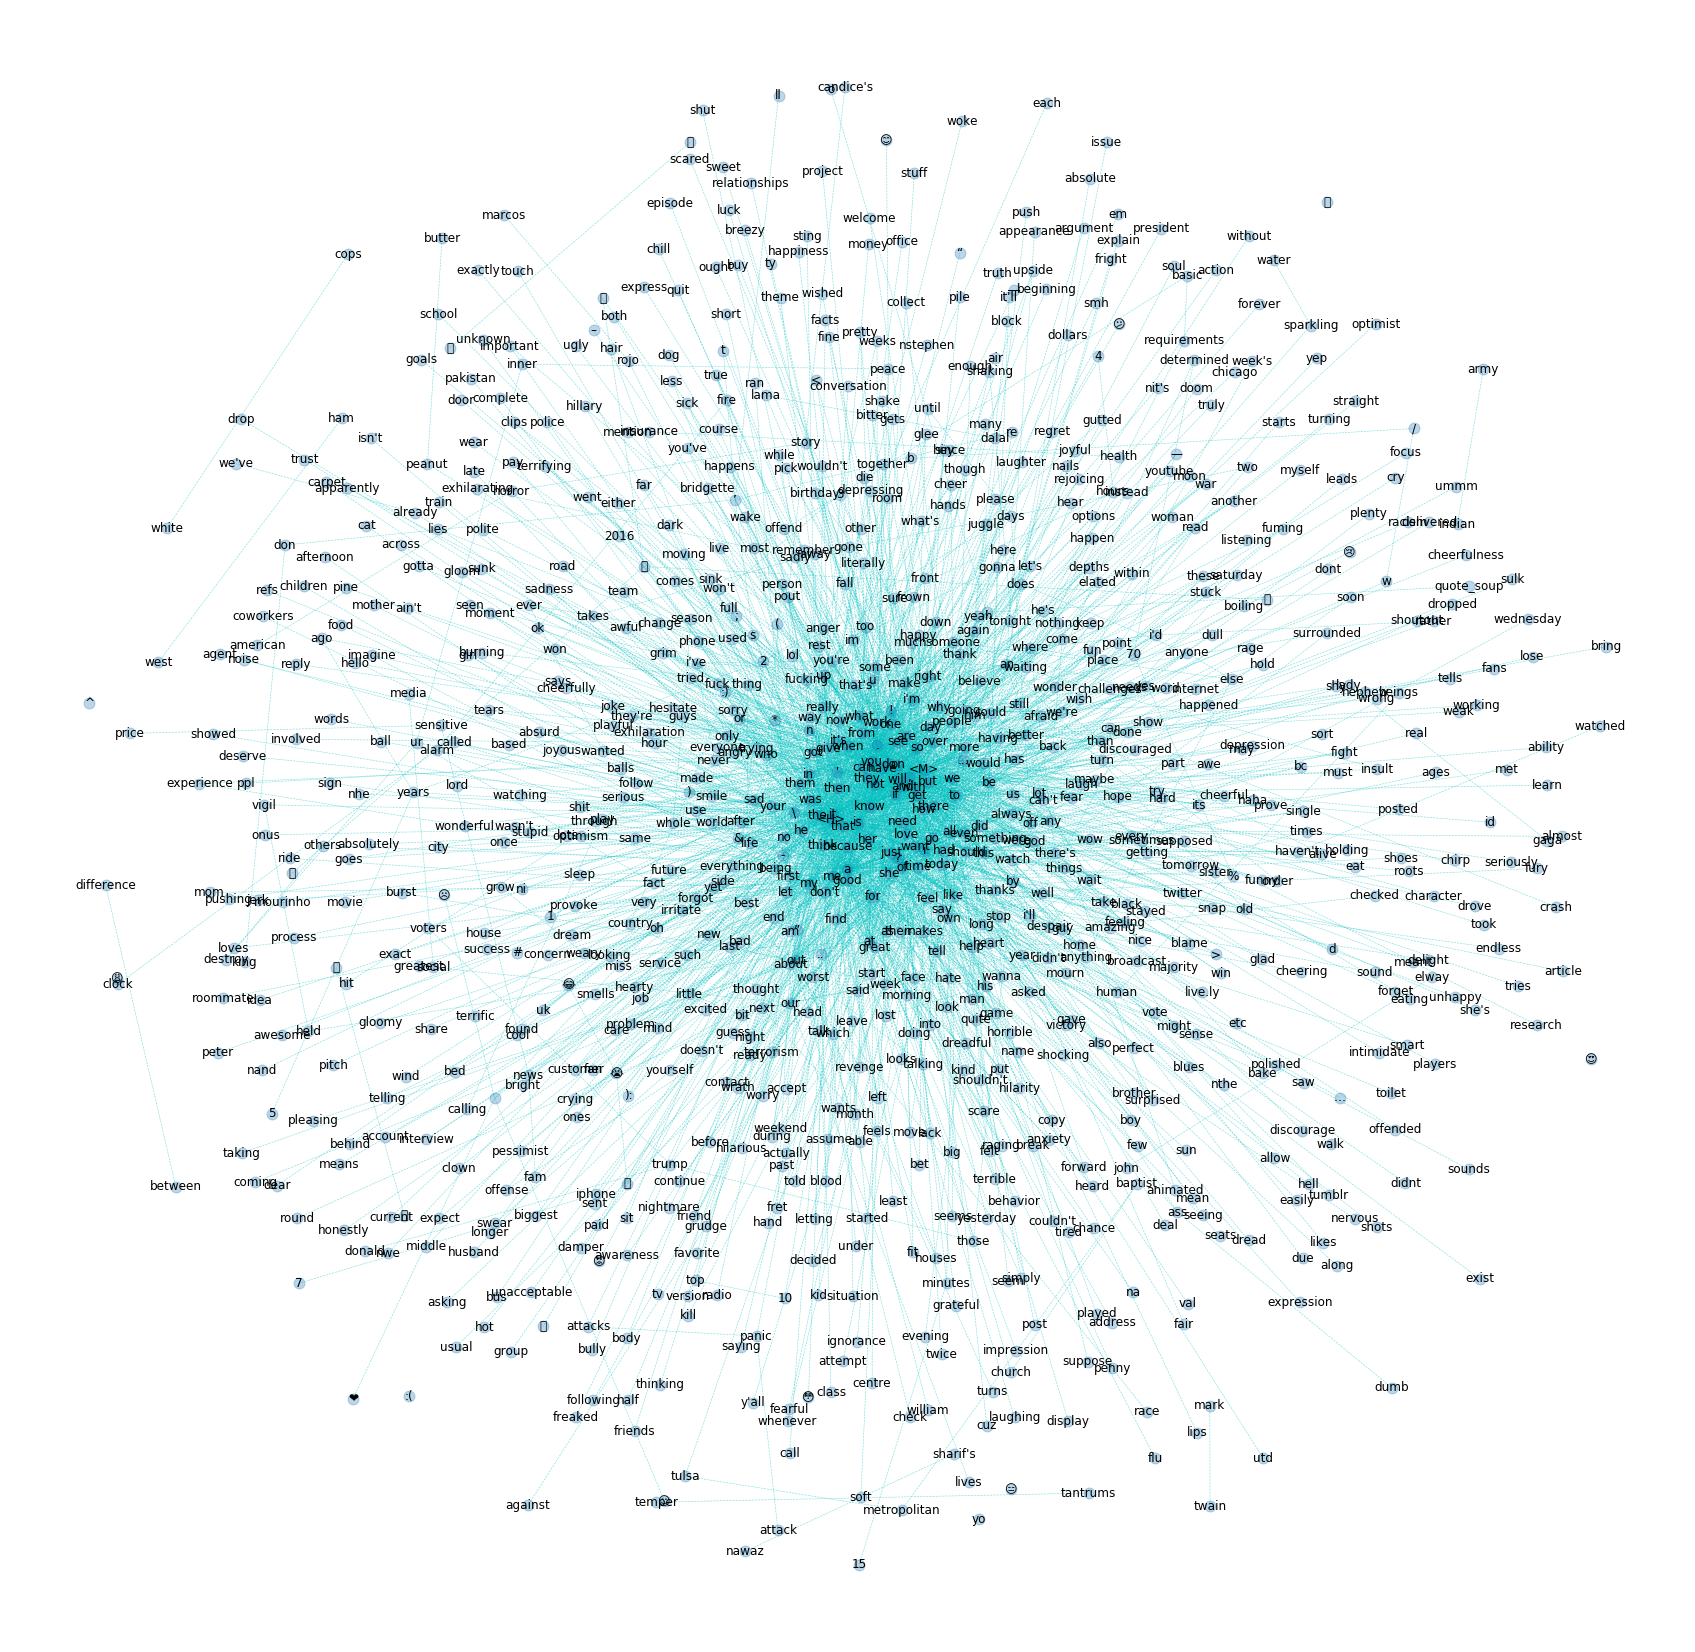

In [5]:
# graph visualization
idea.graph.show(graph_sub)

Here I skip the `graph aggregation` part (graph_emo = graph_sub - graph_obj), it can be operated by `graph_utils.graph_minus()`

In [6]:
# graph_emo = graph_utils.graph_minus(graph_sub, graph_obj)

# Using the same graph to extract patterns.
graph_emo = graph_sub

---
## 2. Token Categorization (CW, SW)

<br>
<img src="./img/2_TC.png" width="860">

Determine the `Connector words` and `Subject words` by `eigenvector centrality` and `clustering coeffcient` respectively.     
(by `idea.graph.measure_ec_cc()`)

In [7]:
# input: graph
df_ec, df_cc = idea.graph.measure_ec_cc(graph_emo, show_time=True)

print('eigenvector centrality, clustering coeffcient')
display_df('df_ec.head(10)', 'df_cc.head(10)')

eigenvector centrality cost:  0.043840885162353516
clustering coefficitnt cost:  0.16558313369750977
eigenvector centrality, clustering coeffcient


df_ec.head(10)
   token     value
2      .  0.256881
0    <H>  0.220465
1    <M>  0.220353
8    the  0.219442
15     ,  0.204646
32     a  0.176782
10    to  0.171004
25    is  0.155122
6      i  0.153904
61  that  0.152587

df_cc.head(10)
        token  value
350     mourn    1.0
585  horrible    1.0
978        ):    1.0
975    within    1.0
252      he's    1.0
254     which    1.0
255  happened    1.0
602     blood    1.0
262      pick    1.0
973        uk    1.0

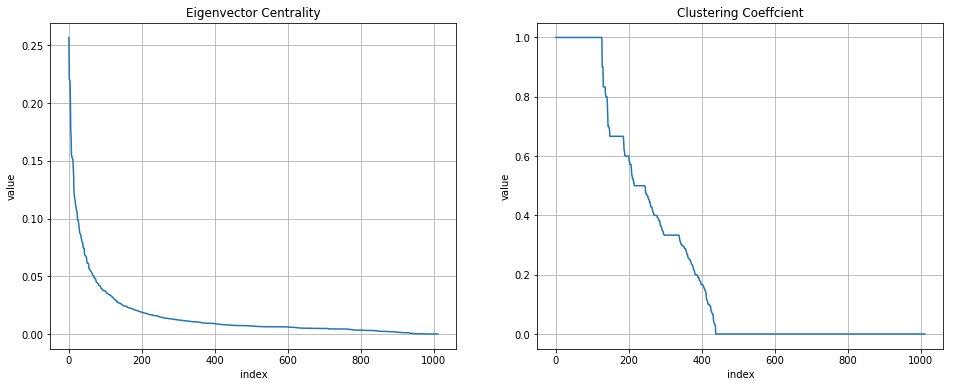

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualization
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(df_ec['value'].values)
plt.title('Eigenvector Centrality')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_cc['value'].values)
plt.title('Clustering Coeffcient')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.show()

### Decide the threshold for CW & SW
User-definded threshold (`threshold_ec`, `threshold_cc`)

In [9]:
# ec for CW, cc for SW
threshold_ec = 0.025
threshold_cc = 0.3333

In [10]:
# hint: using frequency to help us decide `threshold_cc`.
df_cc['value'].value_counts().head(8)

0.000000    574
1.000000    127
0.333333     41
0.666667     38
0.500000     29
0.600000     11
0.400000      8
0.833333      6
Name: value, dtype: int64

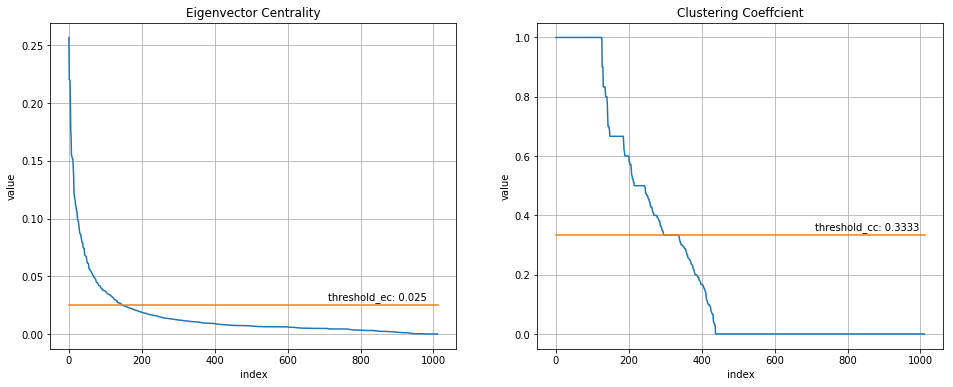

In [11]:
# visualize again
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(df_ec['value'].values)
plt.plot([0, len(df_ec)], [threshold_ec, threshold_ec], linestyle='solid')
plt.text(len(df_ec)-300, threshold_ec+0.005, 'threshold_ec: {}'.format(threshold_ec))
plt.title('Eigenvector Centrality')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_cc['value'].values)
plt.plot([0, len(df_cc)], [threshold_cc, threshold_cc], linestyle='solid')
plt.text(len(df_cc)-300, threshold_cc+0.02, 'threshold_cc: {}'.format(threshold_cc))
plt.title('Clustering Coeffcient')
plt.xlabel('index')
plt.ylabel('value')
plt.grid(True)

plt.show()

### Obtain CW list & SW list

Based on the thresholds, we obtain the `CW_list` and `SW_list`. (by `idea.pattern.listcwsw()`)

In [12]:
CW_list = idea.pattern.listcwsw(df=df_ec, threshold=threshold_ec)
SW_list = idea.pattern.listcwsw(df=df_cc, threshold=threshold_cc)

print('CW_list: ', CW_list[:8], ' ...')
print('SW_list: ', SW_list[:8], ' ...')

CW_list:  ['.' '<H>' '<M>' 'the' ',' 'a' 'to' 'is']  ...
SW_list:  ['mourn' 'horrible' '):' 'within' "he's" 'which' 'happened' 'blood']  ...


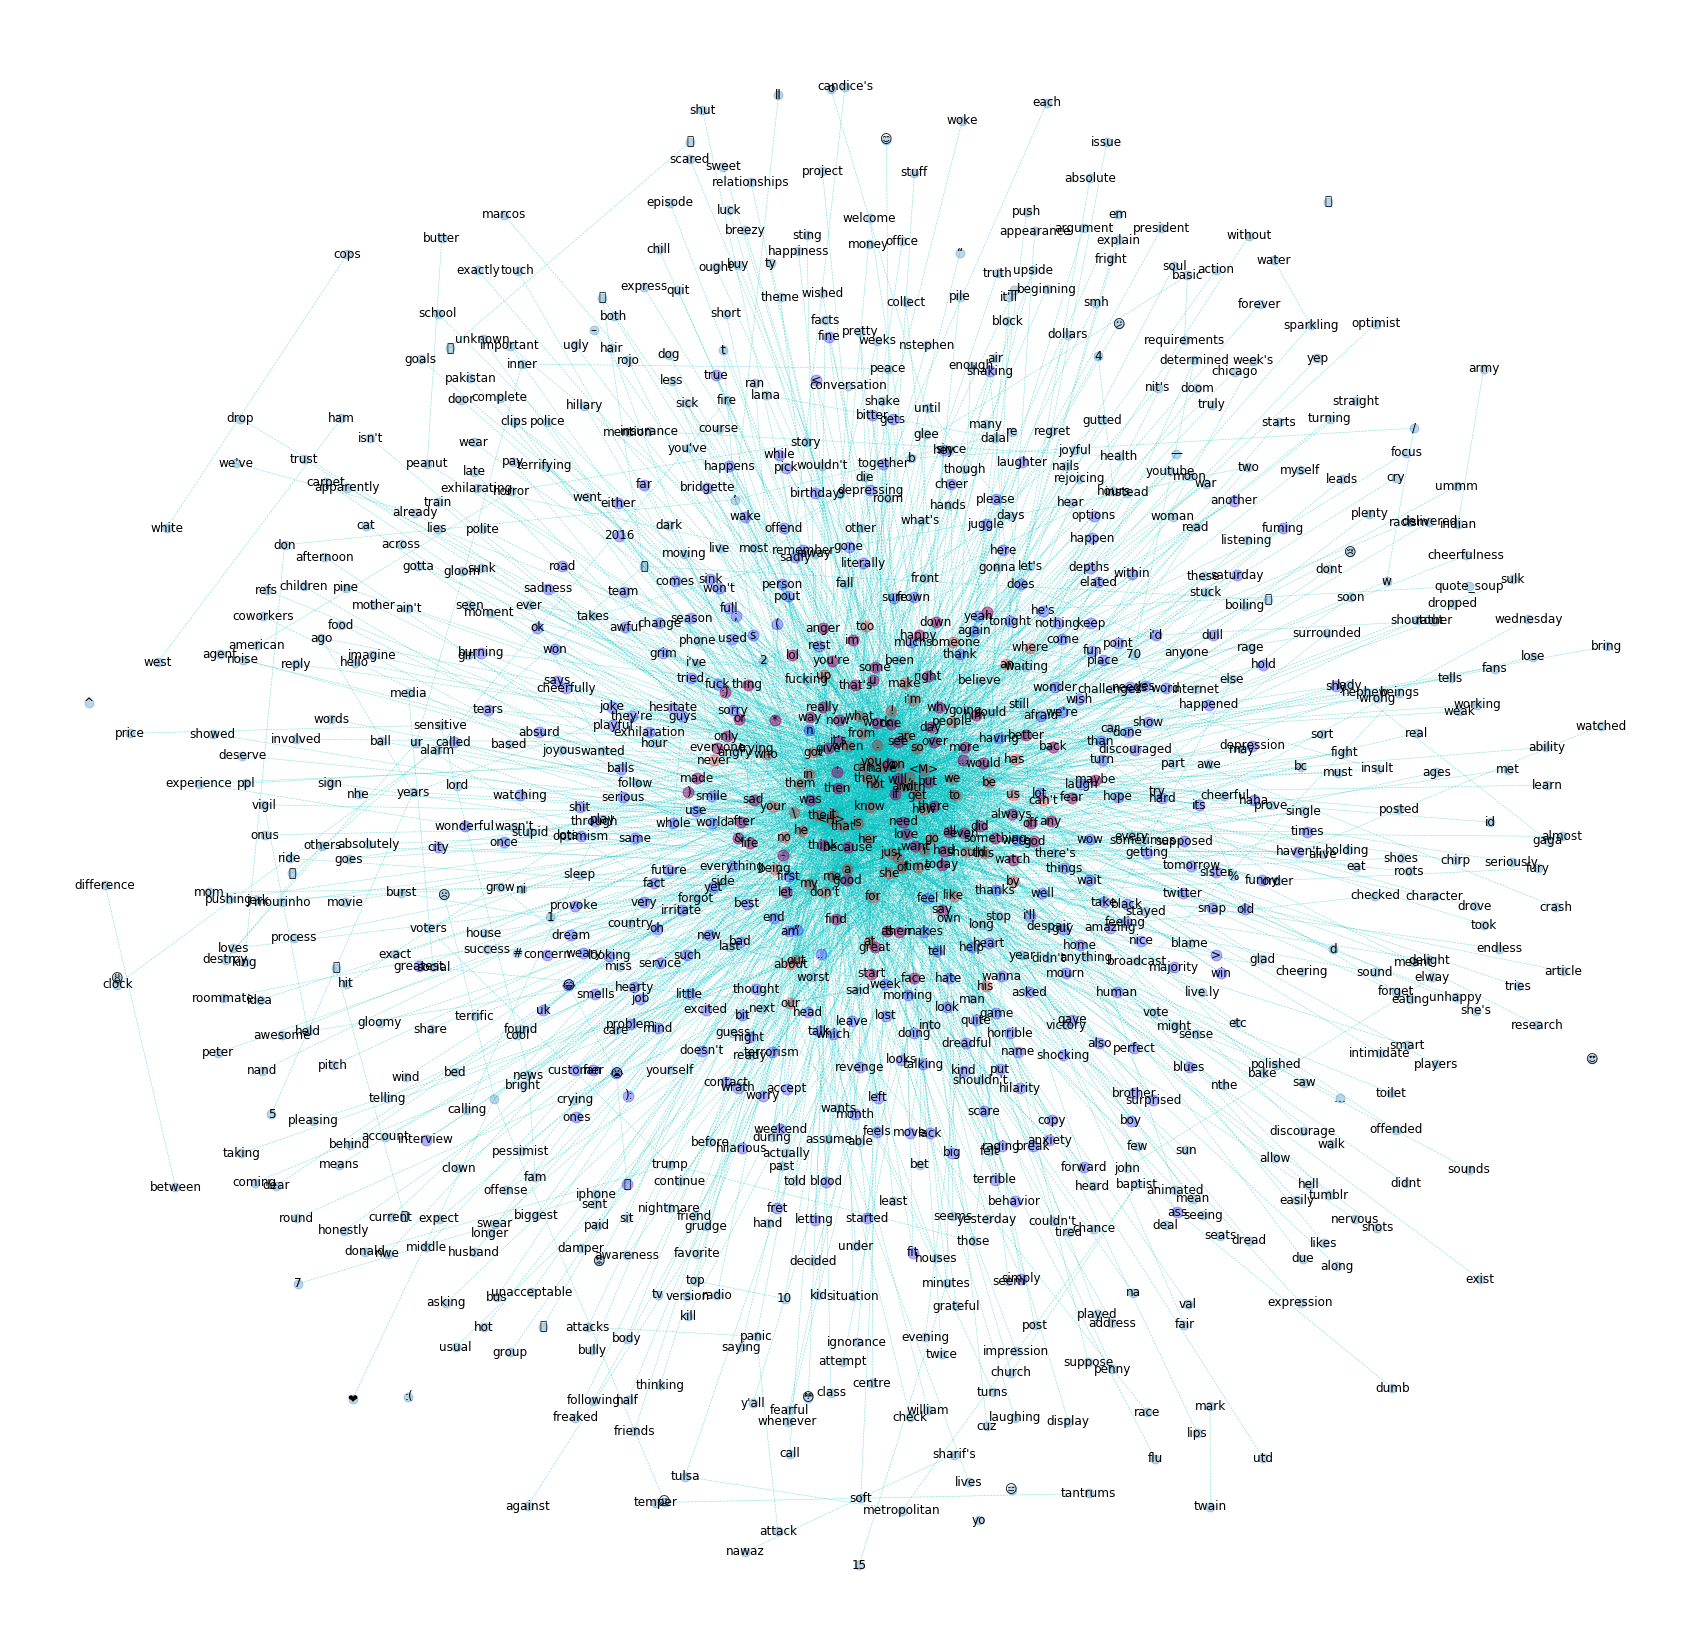

In [13]:
## visualize cw sw
"""
orange: cw
blue: sw
purple: both
"""
idea.graph.show_cwsw(graph_emo, list(CW_list), list(SW_list))

In [14]:
# save
cw_file = os.path.join(pattern_dir, 'CW_list.npy')
sw_file = os.path.join(pattern_dir, 'SW_list.npy')

np.save(cw_file, CW_list)
np.save(sw_file, SW_list)
print('save ok\n {}\n {}'.format(cw_file, sw_file))

# load
# CW_list = np.load(cw_file)
# SW_list = np.load(sw_file)

save ok
 ./pattern_dir/CW_list.npy
 ./pattern_dir/SW_list.npy


---
## 3. Pattern extraction
<br>
<img src="./img/3_example_.png" width="600">

### Convert tokens to CW SW

Convert `tokenized_text` column into cwsw type. (by apply `idea.pattern.token2cwsw()`)

In [15]:
df_train['cwsw_text'] = idea.utils.apply_by_multiprocessing(df=df_train['tokenized_text'], 
                        func=idea.pattern.token2cwsw, cw_list=CW_list, sw_list=SW_list, 
                        cw_token='cw', sw_token='sw', none_token='_', both_token='cw', workers=-1)

df_train.head()

emotion  \
1704     fear   
1152     fear   
1038     fear   
3497  sadness   
1940     fear   

                                                                                                     text  \
1704  @realDonaldTrump @KellyannePolls New campaign slogan idea...'I know you are but what am I?'  #Tr...   
1152  We in our own country are so divided in our approach so how could we fight #terrorism and #pakis...   
1038  @twlldun @bbcquestiontime @JacobReesMogg @leicesterliz @normanlamb @CarolineLucas @JuliaHB1 Oh g...   
3497                               #PeopleLikeMeBecause of some unknown reason but I try to discourage it   
1940                                       @BigDaddyx47 awe I'm sorry! I have 2 dogs 3 cats &amp; a snake   

                                                                                           tokenized_text  \
1704  [<M>, <M>, new, campaign, slogan, idea, ..., ', i, know, you, are, but, what, am, i, ?, ', <H>, ...   
1152  [we, in, our, own, country, are, so, divided, in, our, approach, so, how, could, we, fight, <H>,...   
1038  [<M>, <M>, <M>, <M>, <M>, <M>, <M>, oh, god, ,, not, brewer, again, ., the, horror, ,, the, horror]   
3497                                    [<H>, of, some, unknown, reason, but, i, try, to, discourage, it]   
1940                                    [<M>, awe, i'm, sorry, !, i, have, 2, dogs, 3, cats, &, a, snake]   

                                                                              cwsw_text  
1704  [cw, cw, sw, _, _, _, cw, cw, cw, cw, cw, cw, cw, cw, sw, cw, cw, cw, cw, cw, cw]  
1152     [cw, cw, cw, _, _, cw, cw, _, cw, cw, _, cw, cw, _, cw, _, cw, cw, cw, sw, cw]  
1038          [cw, cw, cw, cw, cw, cw, cw, sw, cw, cw, cw, _, sw, cw, cw, _, cw, cw, _]  
3497                                           [cw, cw, cw, _, _, cw, cw, _, cw, _, cw]  
1940                                 [cw, _, cw, sw, cw, cw, cw, _, _, _, _, cw, cw, _]

### Build pattern dictionary

Based on pre-definded `pattern_templates` and the label of this dataset to construct pattern dictionary. (by `idea.pattern.patternDict()`)    

#### Note:
1. Here we provide an argument `n_jobs` to decide multi-processing or single-processing. (default `n_jobs=-1`: using all CPU cores)
2. The rule of patterns is defined in `idea.pattern.patternDict_()`. (we don't concern the `both_token` in this version)

In [16]:
# user-defined pattern templates
pattern_templates = [['cw', 'sw'], 
                     ['cw', 'cw', 'sw']]

# for check the labels
label_list = list(np.sort(np.unique(df_train[label_col].values)))
print('label_list: ', label_list)

# build pattern-dictionary
pattern_dict = idea.pattern.patternDict(df=df_train, label_list=label_list,
                                        pattern_templates=pattern_templates, n_jobs=-1)


label_list:  ['anger', 'fear', 'joy', 'sadness']


In [17]:
# check results
for i, key in enumerate(pattern_dict.keys()):
    show = [val for val in (pattern_dict[key].keys()) if val != 'contents']
    print("'pattern': ", key)
    for inkey in show:
        print("'{}': {}".format(inkey, pattern_dict[key][inkey]), end="\t")
    print()
    print("'contents': {} ...\n".format([' '.join(tok) for tok in pattern_dict[key]['contents'][:5]]))
    if i > 5: break

'pattern':  have *
'template': cw sw	'anger': 6	'fear': 6	'joy': 8	'sadness': 11	
'contents': ['have won', 'have nothing', 'have serious', 'have done', 'have yet'] ...

'pattern':  <M> *
'template': cw sw	'anger': 61	'fear': 61	'joy': 52	'sadness': 48	
'contents': ['<M> new', '<M> take', '<M> snap', '<M> oh', '<M> oh'] ...

'pattern':  better *
'template': cw sw	'anger': 5	'fear': 3	'joy': 3	'sadness': 3	
'contents': ['better game', 'better than', 'better than', 'better than', 'better than'] ...

'pattern':  what *
'template': cw sw	'anger': 6	'fear': 7	'joy': 6	'sadness': 3	
'contents': ['what am', "what he's", 'what point', 'what point', 'what happened'] ...

'pattern':  should have *
'template': cw cw sw	'anger': 2	'fear': 0	'joy': 0	'sadness': 1	
'contents': ['should have won', 'should have lost', 'should have won'] ...

'pattern':  and *
'template': cw sw	'anger': 15	'fear': 24	'joy': 34	'sadness': 27	
'contents': ['and hearty', 'and awful', 'and break', 'and break', 'and here'] .

### pattern dict -> pattern DataFrame

Convert to `pd.DataFrame` is convenient for operate, visualize, save, load. (by `idea.pattern.patternDF()`)

In [18]:
df_pattern = idea.pattern.patternDF(pattern_dict, label_list)

df_pattern.head(20)

pattern  template  anger  fear  joy  sadness  \
0          have *     cw sw      6     6    8       11   
1           <M> *     cw sw     61    61   52       48   
2        better *     cw sw      5     3    3        3   
3          what *     cw sw      6     7    6        3   
4   should have *  cw cw sw      2     0    0        1   
5           and *     cw sw     15    24   34       27   
6       <M> <M> *  cw cw sw     23    19   12        9   
7      but what *  cw cw sw      0     2    0        0   
8      a better *  cw cw sw      2     1    0        0   
9           <H> *     cw sw     14    27    9       13   
10            a *     cw sw     70    72   67       63   
11            , *     cw sw     29    47   21       23   
12         be a *  cw cw sw      1     2    3        0   
13          the *     cw sw     76   106   88       88   
14           to *     cw sw     45    30   26       44   
15      and <H> *  cw cw sw      1     1    0        1   
16      why the *  cw cw sw      3     0    0        0   
17         good *     cw sw      1     3    9        3   
18       in the *  cw cw sw      2    14    7       12   
19       a good *  cw cw sw      1     2    0        0   

                                                                                               contents  
0   [(have, won), (have, nothing), (have, serious), (have, done), (have, yet), (have, thought), (hav...  
1   [(<M>, new), (<M>, take), (<M>, snap), (<M>, oh), (<M>, oh), (<M>, oh), (<M>, <), (<M>, thanks),...  
2   [(better, game), (better, than), (better, than), (better, than), (better, than), (better, than),...  
3   [(what, am), (what, he's), (what, point), (what, point), (what, happened), (what, kind), (what, ...  
4                                      [(should, have, won), (should, have, lost), (should, have, won)]  
5   [(and, hearty), (and, awful), (and, break), (and, break), (and, here), (and, hilarity), (and, br...  
6   [(<M>, <M>, new), (<M>, <M>, take), (<M>, <M>, oh), (<M>, <M>, oh), (<M>, <M>, wow), (<M>, <M>, ...  
7                                                                    [(but, what, am), (but, what, am)]  
8                                             [(a, better, game), (a, better, look), (a, better, game)]  
9   [(<H>, terrorism), (<H>, ;), (<H>, ;), (<H>, ..), (<H>, 😂), (<H>, fan), (<H>, word), (<H>, toget...  
10  [(a, problem), (a, fan), (a, bit), (a, lot), (a, customer), (a, hearty), (a, very), (a, weary), ...  
11  [(,, yeah), (,, feeling), (,, thank), (,, bad), (,, oh), (,, wish), (,, which), (,, oh), (,, ter...  
12      [(be, a, problem), (be, a, fun), (be, a, place), (be, a, fun), (be, a, place), (be, a, little)]  
13  [(the, fuck), (the, morning), (the, optimism), (the, world), (the, new), (the, balls), (the, fir...  
14  [(to, cheerfully), (to, use), (to, help), (to, offend), (to, juggle), (to, offend), (to, hold), ...  
15                                          [(and, <H>, terrorism), (and, <H>, morning), (and, <H>, 🙄)]  
16                                               [(why, the, fuck), (why, the, fuck), (why, the, fuck)]  
17  [(good, old), (good, night), (good, morning), (good, night), (good, morning), (good, morning), (...  
18  [(in, the, morning), (in, the, same), (in, the, future), (in, the, uk), (in, the, am), (in, the,...  
19                                                  [(a, good, old), (a, good, game), (a, good, dream)]

In [20]:
# save
df_pattern_file = os.path.join(pattern_dir, 'df_pattern.pkl')
df_train_file = os.path.join(pattern_dir, 'df_train_dealed.pkl')

df_pattern.to_pickle(df_pattern_file)
df_train.to_pickle(df_train_file)
print('save ok \n {}\n {}'.format(df_pattern_file, df_train_file))

# load
# df_pattern = pd.read_pickle(df_pattern_file)

save ok 
 ./pattern_dir/df_pattern.pkl
 ./pattern_dir/df_train_dealed.pkl


---
## 4. Next step

After pattern extraction, pattern opinion could substitute for word/token opinion on text.   
It means you can design your pattern feature extraction algorithm (e.g. bag-of-patterns, pattern embedding, ...) and apply on your dataset.
